In this experiment, we want to closer examine the working hours. We want to split the data in weeks, calculate the earliest and latest mail in this week and assume this to be the working hours.

In [1]:
%run ../src/parse_mails.py

df = parse_maildir("../data/maildir")

In [2]:
df.head()

,name,date,parsed_date,time,day,tz
../data/maildir/mckay-b/_sent_mail/44.,mckay-b,"Date: Mon, 7 May 2001 04:44:00 -0700 (PDT)\n",2001-05-07 04:44:00-07:00,04:44:00,2001-05-07,PDT
../data/maildir/mckay-b/_sent_mail/11.,mckay-b,"Date: Tue, 3 Oct 2000 01:18:00 -0700 (PDT)\n",2000-10-03 01:18:00-07:00,01:18:00,2000-10-03,PDT
../data/maildir/mckay-b/_sent_mail/38.,mckay-b,"Date: Tue, 8 May 2001 04:11:00 -0700 (PDT)\n",2001-05-08 04:11:00-07:00,04:11:00,2001-05-08,PDT
../data/maildir/mckay-b/_sent_mail/13.,mckay-b,"Date: Wed, 27 Sep 2000 04:51:00 -0700 (PDT)\n",2000-09-27 04:51:00-07:00,04:51:00,2000-09-27,PDT
../data/maildir/mckay-b/_sent_mail/33.,mckay-b,"Date: Wed, 9 May 2001 09:14:00 -0700 (PDT)\n",2001-05-09 09:14:00-07:00,09:14:00,2001-05-09,PDT


First, lets get a better understanding of the data by plotting just the sent mails of one person (ie _Ken Lay, CEO of Enron_) over time.

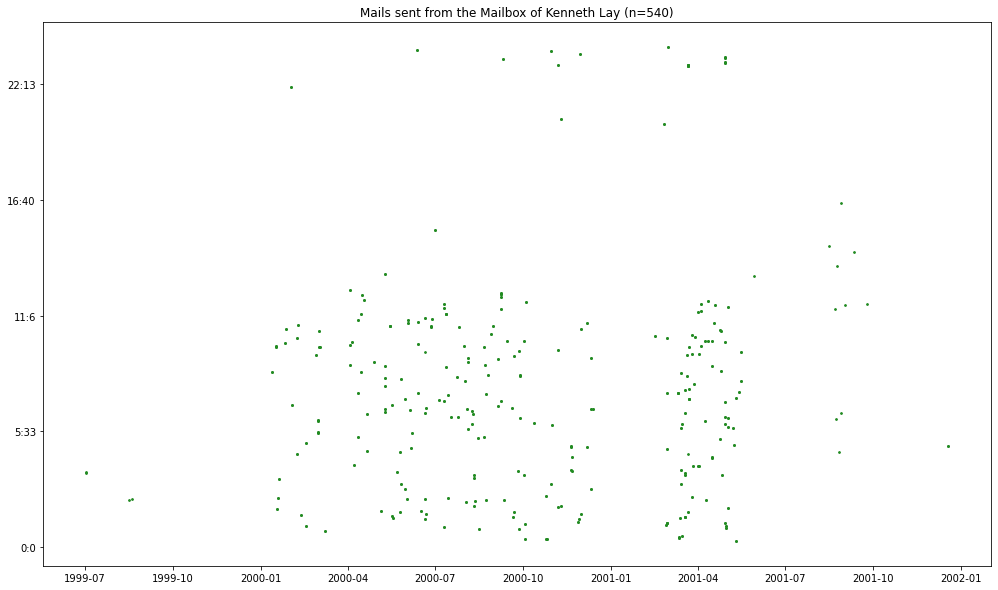

In [66]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df["seconds_since_midnight"] = df["time"].apply(lambda x: x.hour * 60 * 60 + x.minute * 60 + x.second)

k_lay_mails = df[df["name"] == "lay-k"]
def seconds_in_time(x, pos):
    hours = x // 3600
    minutes = (x - (hours * 3600)) // 60
    return '%d:%d' % (hours, minutes)

formatter = FuncFormatter(seconds_in_time)

fig, axs = plt.subplots(1, 1, figsize=(17, 10))
axs.scatter(k_lay_mails["day"], k_lay_mails["seconds_since_midnight"], s=3, c="forestgreen")
axs.yaxis.set_major_formatter(formatter)
axs.set_title(f"Mails sent from the Mailbox of Kenneth Lay (n={len(k_lay_mails)})")
plt.show()


The amount of mails sent by Kenneth Lay is surprisingly small (n=540). Given the timespan, I would expect something in the in the order between 1000-10000 mails sent by **the CEO of a major enterprise**. Maybe there a some mails that he sent, but deleted from his folder? We might need to consider parsing other mail folders as well and match those to the original senders. Still, let's try to compute the working hours for each week.

In [79]:
k_lay_mails["week"] = k_lay_mails["parsed_date"].apply(lambda x: x.isocalendar()[1])
k_lay_mails["year"] = k_lay_mails["parsed_date"].apply(lambda x: x.year)

k_lay_working_hours = k_lay_mails.groupby(["year", "week"])["seconds_since_midnight"].agg(["max", "min"])
type(k_lay_working_hours["max"])

/tmp/ipykernel_1983/2402275491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_lay_mails["week"] = k_lay_mails["parsed_date"].apply(lambda x: x.isocalendar()[1])
/tmp/ipykernel_1983/2402275491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_lay_mails["year"] = k_lay_mails["parsed_date"].apply(lambda x: x.year)


pandas.core.series.Series

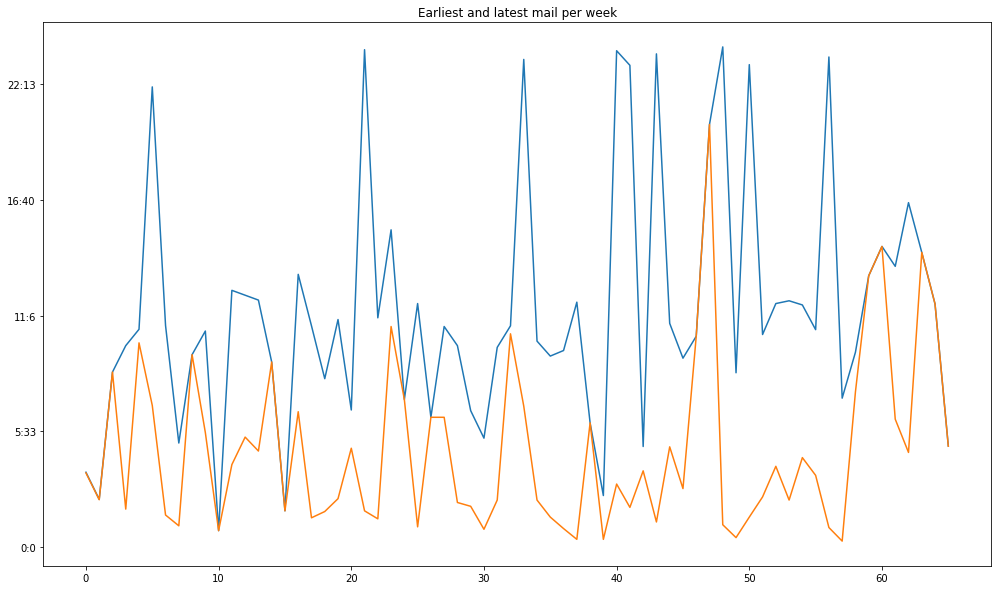

In [81]:
fig, axs = plt.subplots(1, 1, figsize=(17, 10))
axs.plot(np.array(k_lay_working_hours))
axs.set_title(f"Earliest and latest mail per week")
axs.yaxis.set_major_formatter(formatter)
plt.show()

This plot looks very rough, probably because of some outliers. Let's calulate the mean of each month.

In [86]:
k_lay_mails["month"] = k_lay_mails["parsed_date"].apply(lambda x: x.month)
k_lay_working_hours_avg = k_lay_mails.groupby(["year", "month", "week"])["seconds_since_midnight"].agg(["max", "min"]).groupby(["year", "month"]).agg("mean")

/tmp/ipykernel_1983/1832849093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_lay_mails["month"] = k_lay_mails["parsed_date"].apply(lambda x: x.month)


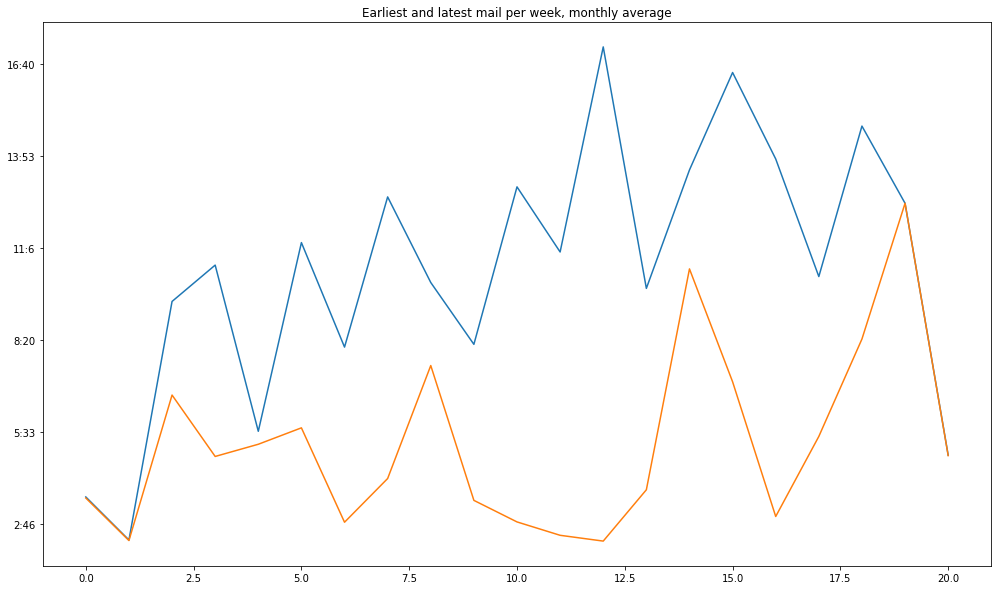

In [88]:
fig, axs = plt.subplots(1, 1, figsize=(17, 10))
axs.plot(np.array(k_lay_working_hours_avg))
axs.set_title(f"Earliest and latest mail per week, monthly average")
axs.yaxis.set_major_formatter(formatter)
plt.show()

This looks better. Let's apply it to all people in the dataset.

In [112]:
df["week"] = df["parsed_date"].apply(lambda x: x.isocalendar()[1])
df["year"] = df["parsed_date"].apply(lambda x: x.year)
df["month"] = df["parsed_date"].apply(lambda x: x.month)
avg_working_hours = df.groupby(["name","year", "month", "week"])["seconds_since_midnight"].agg(["max", "min"]).groupby(["name", "year", "month"]).agg("mean").reset_index(level="name")

In [135]:
avg_working_hours[avg_working_hours["name"] == "lay-k"][["max", "min"]]

max           min
year month                            
1999 7      12960.000000  12840.000000
     8       8280.000000   8220.000000
2000 1      34220.000000  24040.000000
     2      38172.000000  17364.000000
     3      20100.000000  18690.000000
     4      40620.000000  20475.000000
     5      29256.000000  10212.000000
     6      45588.000000  14964.000000
     7      36280.000000  27250.000000
     8      29556.000000  12588.000000
     9      46680.000000  10245.000000
     10     39600.000000   8790.000000
     11     61900.000000   8160.000000
     12     35640.000000  13740.000000
2001 2      48520.000000  37760.000000
     3      59115.000000  25485.000000
     4      49716.000000  10836.000000
     5      36926.750000  19541.750000
     8      53290.000000  30133.666667
     9      44896.333333  44896.333333
     12     17504.000000  17453.000000

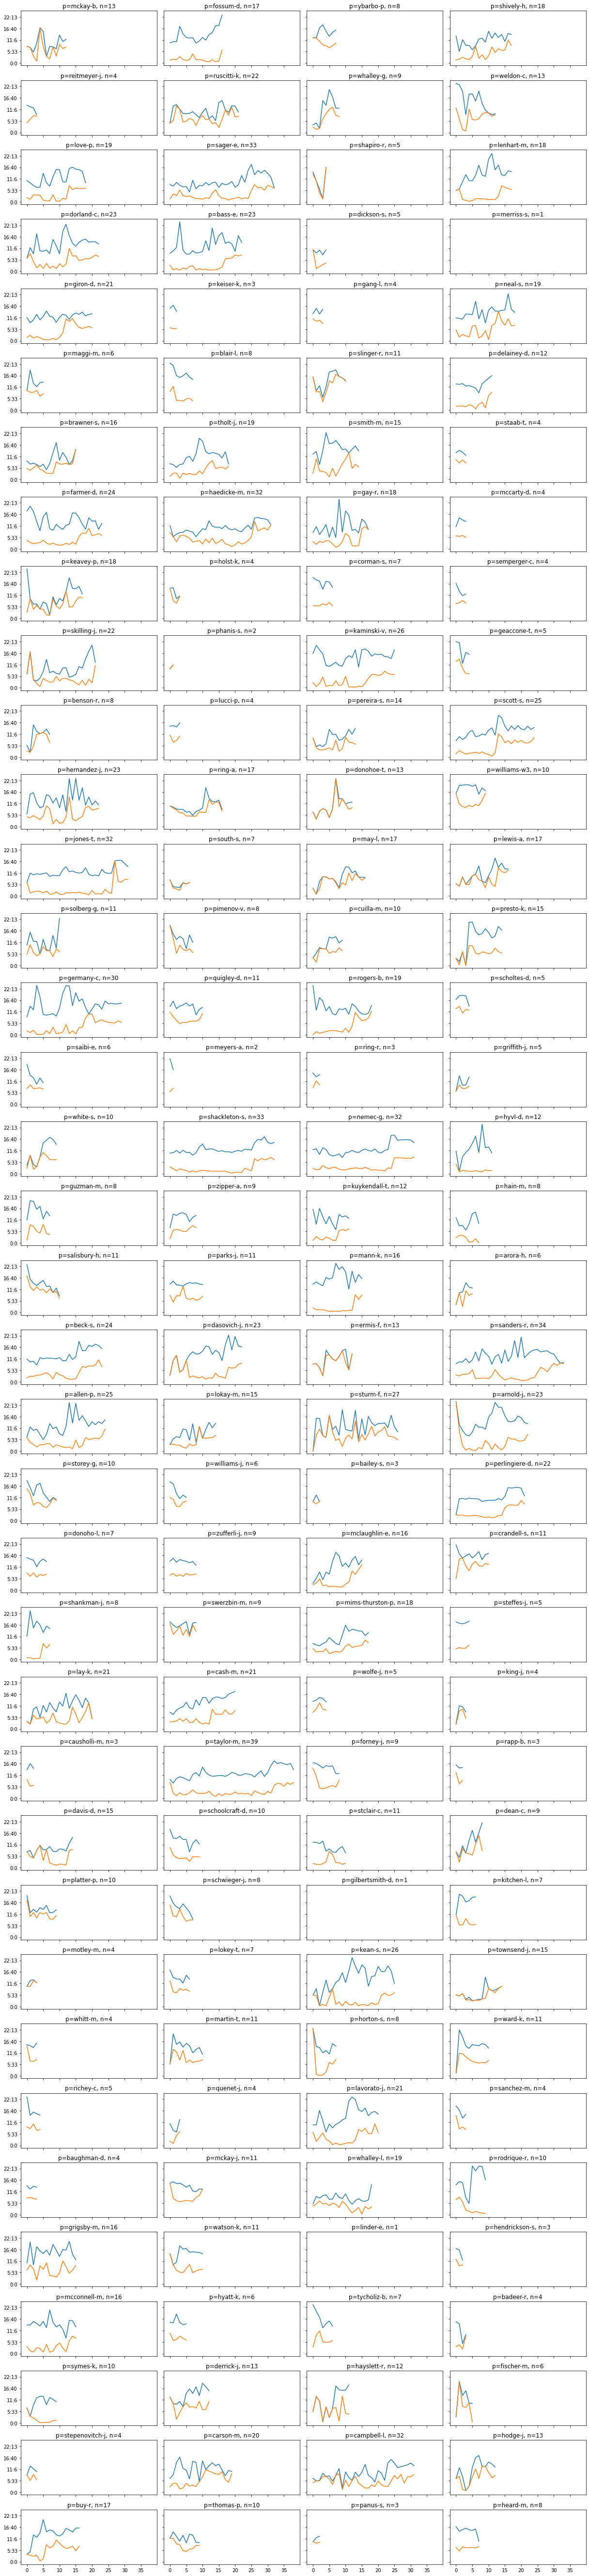

In [144]:
names = df["name"].unique()
fig, axs = plt.subplots(37, 4, figsize=(17, 74), sharey=True, sharex=True)
for i in range(len(names)):
    current_row = i // 4
    current_col = i % 4
    current_dataset = avg_working_hours[avg_working_hours["name"] == names[i]][["max", "min"]]
    axs[current_row][current_col].plot(np.array(current_dataset))
    axs[current_row][current_col].yaxis.set_major_formatter(formatter)
    axs[current_row][current_col].set_title(f"p={names[i]}, n={len(current_dataset)}")
fig.tight_layout()
fig.savefig('exp003_all.pdf')
plt.show()



The x-position in those plots is not correct; the date information is currently lost. This plot already shows that we have tiny ns per person.

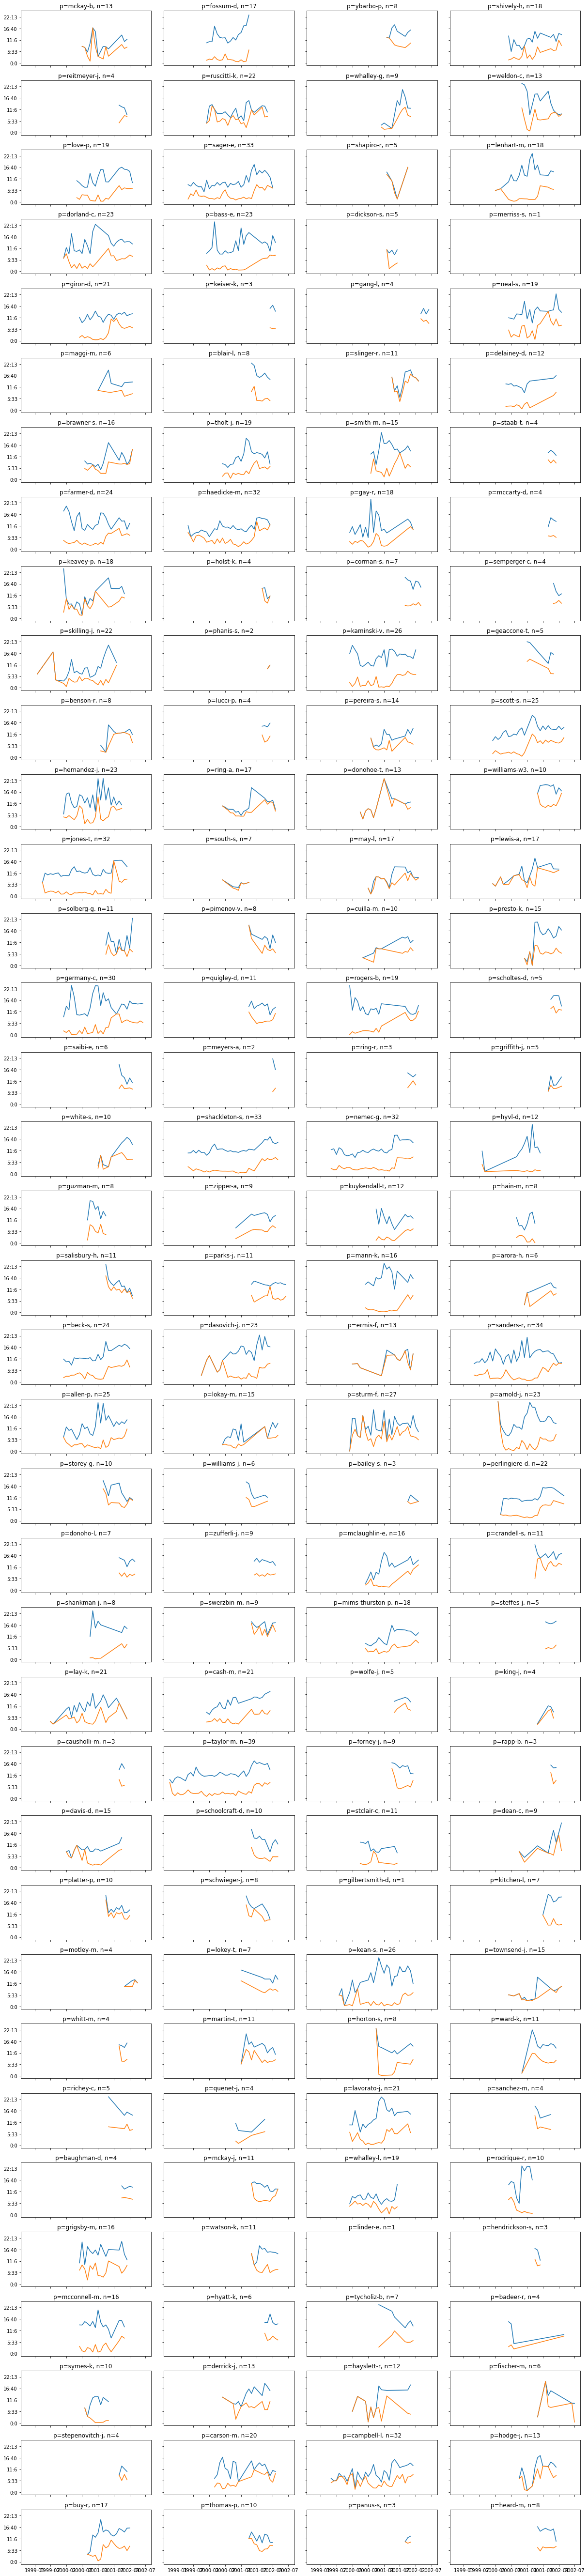

In [167]:
fig, axs = plt.subplots(37, 4, figsize=(17, 74), sharey=True, sharex=True)
avg_working_hours_reset = avg_working_hours.reset_index()
avg_working_hours_reset["day"] = 1
avg_working_hours_reset["x"] = pd.to_datetime(avg_working_hours_reset[["year", "month", "day"]])
for i in range(len(names)):
    current_row = i // 4
    current_col = i % 4
    current_dataset = avg_working_hours_reset[avg_working_hours_reset["name"] == names[i]]
    axs[current_row][current_col].plot(np.array(current_dataset["x"]), np.array(current_dataset[["max", "min"]]))
    axs[current_row][current_col].yaxis.set_major_formatter(formatter)
    axs[current_row][current_col].set_title(f"p={names[i]}, n={len(current_dataset)}")
fig.tight_layout()
fig.savefig('exp003_all.pdf')
plt.show()